<div style="text-align:right"><span style="color:black; font-family:Georgia; font-size:1em">Document Created Date:12-03-2019</div></span>

<div style="text-align:center"><span style="color:green; font-family:Georgia; font-size:3em;">Self Driving Car - Case Study</span></div>

<img src=selfdrivingcar.png>

<hr>
## Dataset

- Refer this: https://github.com/SullyChen/Autopilot-TensorFlow

- There are total 45406 images in the dataset along with their steering angles. We will split the dataset into train and test in a ratio of 70:30 sequentially.

## Objective

- Our objective is to predict the correct steering angle from the given test image of the road. Here, our loss is Mean Squared Error(MSE). Our goal is to reduce the MSE error as low as possible.

## Prerequisites
- we need to  installed following softwares and libraries in our machine before running this project.

- Python 3: https://www.python.org/downloads/

- Anaconda: It will install ipython notebook and most of the libraries which are needed like pandas, matplotlib, numpy and scipy: https://www.anaconda.com/download/

* Libraries:

- Tensorflow: It is a deep learning library.
- pip install tensorflow

- OpenCV: It is used for processing images.
- pip install opencv-python


In [2]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

### 1. Train Test Split (70:30)

In [1]:
# read images and steering angles from driving_dataset folder

from __future__ import division

import os
import numpy as np
import random

from scipy import pi
from itertools import islice



DATA_FOLDER = './driving_dataset/' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


split =0.7
X = []
y = []
with open(TRAIN_FILE) as fp:
    for line in fp:
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )
        

y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*0.7)

train_y = y[:split_index]
test_y = y[split_index:]

Completed processing data.txt


In [20]:
import scipy.misc
import random

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out


C:\Users\ramesh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


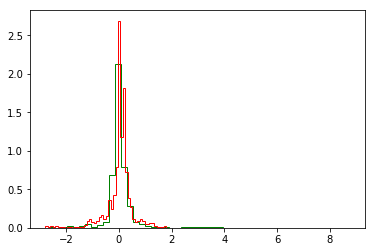

In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy;

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()




In [4]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
del np
import numpy as np
train_mean_y = np.mean(train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )


Test_MSE(MEAN):0.241561
Test_MSE(ZERO):0.241107


## Model Code:

In [12]:
# model.py
import tensorflow as tf
import scipy

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#Fully Connected Layer 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#ully Connected Layer 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#ully Connected Layer 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 4
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

#y = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output
y = tf.multiply((tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output


In [10]:
%%time
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model


LOGDIR = './My Final Save'

sess = tf.InteractiveSession()


L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(driving_data.num_images/batch_size)):
    xs, ys = driving_data.LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
    if i % 10 == 0:
      xs, ys = driving_data.LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)
print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

Epoch: 0, Step: 0, Loss: 7.75127
Epoch: 0, Step: 10, Loss: 6.20833
Epoch: 0, Step: 20, Loss: 6.05425
Epoch: 0, Step: 30, Loss: 6.02217
Epoch: 0, Step: 40, Loss: 5.97837
Epoch: 0, Step: 50, Loss: 5.94729
Epoch: 0, Step: 60, Loss: 5.89532
Epoch: 0, Step: 70, Loss: 5.8629
Epoch: 0, Step: 80, Loss: 5.83926
Epoch: 0, Step: 90, Loss: 5.78082
Epoch: 0, Step: 100, Loss: 5.74553
Epoch: 0, Step: 110, Loss: 5.72495
Epoch: 0, Step: 120, Loss: 5.67633
Epoch: 0, Step: 130, Loss: 5.64497
Epoch: 0, Step: 140, Loss: 5.60164
Epoch: 0, Step: 150, Loss: 5.56196
Epoch: 0, Step: 160, Loss: 5.53261
Epoch: 0, Step: 170, Loss: 5.49706
Epoch: 0, Step: 180, Loss: 5.52294
Epoch: 0, Step: 190, Loss: 5.42563
Epoch: 0, Step: 200, Loss: 10.7536
Epoch: 0, Step: 210, Loss: 5.86669
Epoch: 0, Step: 220, Loss: 5.30538
Epoch: 0, Step: 230, Loss: 5.27461
Epoch: 0, Step: 240, Loss: 5.24593
Epoch: 0, Step: 250, Loss: 5.21658
Epoch: 0, Step: 260, Loss: 5.16357
Epoch: 0, Step: 270, Loss: 5.28289
Epoch: 0, Step: 280, Loss: 5.222

Epoch: 2, Step: 310, Loss: 3.32029
Epoch: 2, Step: 320, Loss: 3.30181
Epoch: 2, Step: 330, Loss: 3.28289
Epoch: 2, Step: 340, Loss: 3.26601
Epoch: 2, Step: 350, Loss: 3.24826
Epoch: 2, Step: 360, Loss: 3.23224
Epoch: 2, Step: 370, Loss: 3.26979
Epoch: 2, Step: 380, Loss: 3.3427
Epoch: 2, Step: 390, Loss: 8.76966
Epoch: 2, Step: 400, Loss: 3.19246
Epoch: 2, Step: 410, Loss: 3.14179
Epoch: 2, Step: 420, Loss: 3.14061
Epoch: 2, Step: 430, Loss: 3.13819
Epoch: 2, Step: 440, Loss: 3.12208
Epoch: 2, Step: 450, Loss: 3.07646
Epoch: 2, Step: 460, Loss: 3.22973
Epoch: 2, Step: 470, Loss: 3.10662
Epoch: 2, Step: 480, Loss: 3.02213
Epoch: 2, Step: 490, Loss: 3.07834
Epoch: 2, Step: 500, Loss: 2.99153
Epoch: 2, Step: 510, Loss: 3.00073
Epoch: 2, Step: 520, Loss: 2.98347
Epoch: 2, Step: 530, Loss: 3.04276
Epoch: 2, Step: 540, Loss: 2.98346
Epoch: 2, Step: 550, Loss: 3.06819
Epoch: 2, Step: 560, Loss: 2.96426
Epoch: 2, Step: 570, Loss: 2.89572
Epoch: 2, Step: 580, Loss: 2.86959
Epoch: 2, Step: 590, 

Epoch: 4, Step: 610, Loss: 1.98416
Epoch: 4, Step: 620, Loss: 1.98744
Epoch: 4, Step: 630, Loss: 1.97921
Epoch: 4, Step: 640, Loss: 1.94389
Epoch: 4, Step: 650, Loss: 2.06862
Epoch: 4, Step: 660, Loss: 1.92765
Epoch: 4, Step: 670, Loss: 1.90278
Epoch: 4, Step: 680, Loss: 1.93585
Epoch: 4, Step: 690, Loss: 1.89473
Epoch: 4, Step: 700, Loss: 1.87811
Epoch: 4, Step: 710, Loss: 1.90628
Epoch: 4, Step: 720, Loss: 1.92776
Epoch: 4, Step: 730, Loss: 1.92996
Epoch: 4, Step: 740, Loss: 1.95085
Epoch: 4, Step: 750, Loss: 1.84316
Epoch: 4, Step: 760, Loss: 1.83397
Epoch: 4, Step: 770, Loss: 1.8095
Epoch: 4, Step: 780, Loss: 1.79123
Epoch: 4, Step: 790, Loss: 1.78362
Epoch: 4, Step: 800, Loss: 1.78311
Epoch: 4, Step: 810, Loss: 1.76657
Epoch: 4, Step: 820, Loss: 1.75642
Epoch: 4, Step: 830, Loss: 1.76171
Epoch: 4, Step: 840, Loss: 1.73943
Epoch: 4, Step: 850, Loss: 1.73471
Model saved in file: ./My Final Save\model.ckpt
Epoch: 5, Step: 500, Loss: 1.73286
Epoch: 5, Step: 510, Loss: 1.72516
Epoch: 5

Epoch: 6, Step: 910, Loss: 1.23323
Epoch: 6, Step: 920, Loss: 1.28959
Epoch: 6, Step: 930, Loss: 1.2853
Epoch: 6, Step: 940, Loss: 1.18113
Epoch: 6, Step: 950, Loss: 1.17218
Epoch: 6, Step: 960, Loss: 1.16571
Epoch: 6, Step: 970, Loss: 1.16621
Epoch: 6, Step: 980, Loss: 1.1636
Epoch: 6, Step: 990, Loss: 1.15807
Epoch: 6, Step: 1000, Loss: 1.14737
Epoch: 6, Step: 1010, Loss: 1.1394
Epoch: 6, Step: 1020, Loss: 1.14757
Epoch: 6, Step: 1030, Loss: 1.13721
Epoch: 6, Step: 1040, Loss: 1.13403
Epoch: 6, Step: 1050, Loss: 1.11796
Model saved in file: ./My Final Save\model.ckpt
Epoch: 7, Step: 700, Loss: 1.13837
Epoch: 7, Step: 710, Loss: 1.168
Epoch: 7, Step: 720, Loss: 1.12584
Epoch: 7, Step: 730, Loss: 1.60219
Epoch: 7, Step: 740, Loss: 1.52099
Epoch: 7, Step: 750, Loss: 1.20105
Epoch: 7, Step: 760, Loss: 1.09661
Epoch: 7, Step: 770, Loss: 1.08598
Epoch: 7, Step: 780, Loss: 1.09806
Epoch: 7, Step: 790, Loss: 1.21259
Epoch: 7, Step: 800, Loss: 1.74133
Epoch: 7, Step: 810, Loss: 1.39028
Epoch:

Epoch: 8, Step: 1210, Loss: 0.743837
Epoch: 8, Step: 1220, Loss: 0.738499
Epoch: 8, Step: 1230, Loss: 0.737928
Epoch: 8, Step: 1240, Loss: 0.744095
Epoch: 8, Step: 1250, Loss: 0.737575
Model saved in file: ./My Final Save\model.ckpt
Epoch: 9, Step: 900, Loss: 0.750154
Epoch: 9, Step: 910, Loss: 0.805261
Epoch: 9, Step: 920, Loss: 1.15378
Epoch: 9, Step: 930, Loss: 1.01628
Epoch: 9, Step: 940, Loss: 0.777655
Epoch: 9, Step: 950, Loss: 0.720071
Epoch: 9, Step: 960, Loss: 0.718376
Epoch: 9, Step: 970, Loss: 0.739094
Epoch: 9, Step: 980, Loss: 1.01148
Epoch: 9, Step: 990, Loss: 1.79317
Epoch: 9, Step: 1000, Loss: 1.10926
Epoch: 9, Step: 1010, Loss: 0.842861
Epoch: 9, Step: 1020, Loss: 0.700255
Epoch: 9, Step: 1030, Loss: 0.689749
Epoch: 9, Step: 1040, Loss: 0.682704
Epoch: 9, Step: 1050, Loss: 0.682122
Epoch: 9, Step: 1060, Loss: 0.703511
Epoch: 9, Step: 1070, Loss: 0.749881
Epoch: 9, Step: 1080, Loss: 0.671782
Epoch: 9, Step: 1090, Loss: 0.73211
Epoch: 9, Step: 1100, Loss: 0.868981
Epoch:

Epoch: 11, Step: 1110, Loss: 1.06604
Epoch: 11, Step: 1120, Loss: 0.761906
Epoch: 11, Step: 1130, Loss: 0.579462
Epoch: 11, Step: 1140, Loss: 0.490436
Epoch: 11, Step: 1150, Loss: 0.491154
Epoch: 11, Step: 1160, Loss: 0.521472
Epoch: 11, Step: 1170, Loss: 0.639107
Epoch: 11, Step: 1180, Loss: 0.845702
Epoch: 11, Step: 1190, Loss: 0.616395
Epoch: 11, Step: 1200, Loss: 0.533382
Epoch: 11, Step: 1210, Loss: 0.479862
Epoch: 11, Step: 1220, Loss: 0.537228
Epoch: 11, Step: 1230, Loss: 0.539619
Epoch: 11, Step: 1240, Loss: 0.564174
Epoch: 11, Step: 1250, Loss: 0.51959
Epoch: 11, Step: 1260, Loss: 0.551592
Epoch: 11, Step: 1270, Loss: 0.476768
Epoch: 11, Step: 1280, Loss: 0.502632
Epoch: 11, Step: 1290, Loss: 0.812494
Epoch: 11, Step: 1300, Loss: 0.533979
Epoch: 11, Step: 1310, Loss: 0.657811
Epoch: 11, Step: 1320, Loss: 0.45525
Epoch: 11, Step: 1330, Loss: 0.458802
Epoch: 11, Step: 1340, Loss: 0.464633
Epoch: 11, Step: 1350, Loss: 0.464173
Epoch: 11, Step: 1360, Loss: 0.490909
Epoch: 11, Step

Epoch: 13, Step: 1390, Loss: 0.408309
Epoch: 13, Step: 1400, Loss: 0.331563
Epoch: 13, Step: 1410, Loss: 0.33032
Epoch: 13, Step: 1420, Loss: 0.333703
Epoch: 13, Step: 1430, Loss: 0.336599
Epoch: 13, Step: 1440, Loss: 0.364611
Epoch: 13, Step: 1450, Loss: 0.362831
Epoch: 13, Step: 1460, Loss: 0.328272
Epoch: 13, Step: 1470, Loss: 0.430987
Epoch: 13, Step: 1480, Loss: 0.724504
Epoch: 13, Step: 1490, Loss: 0.417147
Epoch: 13, Step: 1500, Loss: 0.566525
Epoch: 13, Step: 1510, Loss: 0.377467
Epoch: 13, Step: 1520, Loss: 0.354474
Epoch: 13, Step: 1530, Loss: 0.33573
Epoch: 13, Step: 1540, Loss: 0.38547
Epoch: 13, Step: 1550, Loss: 0.415976
Epoch: 13, Step: 1560, Loss: 5.67149
Epoch: 13, Step: 1570, Loss: 0.595297
Epoch: 13, Step: 1580, Loss: 0.351793
Epoch: 13, Step: 1590, Loss: 0.370323
Epoch: 13, Step: 1600, Loss: 0.345886
Epoch: 13, Step: 1610, Loss: 0.348671
Epoch: 13, Step: 1620, Loss: 0.523204
Epoch: 13, Step: 1630, Loss: 0.452953
Epoch: 13, Step: 1640, Loss: 0.337348
Epoch: 13, Step:

Epoch: 15, Step: 1630, Loss: 0.32434
Epoch: 15, Step: 1640, Loss: 0.304472
Epoch: 15, Step: 1650, Loss: 0.372258
Epoch: 15, Step: 1660, Loss: 0.286733
Epoch: 15, Step: 1670, Loss: 0.589346
Epoch: 15, Step: 1680, Loss: 0.438868
Epoch: 15, Step: 1690, Loss: 0.284875
Epoch: 15, Step: 1700, Loss: 0.251212
Epoch: 15, Step: 1710, Loss: 0.251169
Epoch: 15, Step: 1720, Loss: 0.251322
Epoch: 15, Step: 1730, Loss: 0.251237
Epoch: 15, Step: 1740, Loss: 0.450997
Epoch: 15, Step: 1750, Loss: 5.46736
Epoch: 15, Step: 1760, Loss: 0.339155
Epoch: 15, Step: 1770, Loss: 0.246636
Epoch: 15, Step: 1780, Loss: 0.244554
Epoch: 15, Step: 1790, Loss: 0.252566
Epoch: 15, Step: 1800, Loss: 0.250207
Epoch: 15, Step: 1810, Loss: 0.244064
Epoch: 15, Step: 1820, Loss: 0.241749
Epoch: 15, Step: 1830, Loss: 0.240228
Epoch: 15, Step: 1840, Loss: 0.239241
Epoch: 15, Step: 1850, Loss: 0.239687
Epoch: 15, Step: 1860, Loss: 0.242739
Epoch: 15, Step: 1870, Loss: 0.259491
Epoch: 15, Step: 1880, Loss: 0.268739
Epoch: 15, Ste

Epoch: 17, Step: 1910, Loss: 0.264542
Epoch: 17, Step: 1920, Loss: 0.239096
Epoch: 17, Step: 1930, Loss: 1.05134
Epoch: 17, Step: 1940, Loss: 4.90843
Epoch: 17, Step: 1950, Loss: 0.292661
Epoch: 17, Step: 1960, Loss: 0.256352
Epoch: 17, Step: 1970, Loss: 0.258137
Epoch: 17, Step: 1980, Loss: 0.224039
Epoch: 17, Step: 1990, Loss: 0.298209
Epoch: 17, Step: 2000, Loss: 0.338935
Epoch: 17, Step: 2010, Loss: 0.450148
Epoch: 17, Step: 2020, Loss: 0.762919
Epoch: 17, Step: 2030, Loss: 1.46633
Epoch: 17, Step: 2040, Loss: 1.03262
Epoch: 17, Step: 2050, Loss: 1.42988
Epoch: 17, Step: 2060, Loss: 0.22411
Epoch: 17, Step: 2070, Loss: 0.211901
Epoch: 17, Step: 2080, Loss: 0.264506
Epoch: 17, Step: 2090, Loss: 0.19997
Epoch: 17, Step: 2100, Loss: 0.209299
Epoch: 17, Step: 2110, Loss: 0.199083
Epoch: 17, Step: 2120, Loss: 0.198313
Epoch: 17, Step: 2130, Loss: 0.197875
Epoch: 17, Step: 2140, Loss: 0.197813
Epoch: 17, Step: 2150, Loss: 0.19744
Model saved in file: ./My Final Save\model.ckpt
Epoch: 18,

Epoch: 19, Step: 2210, Loss: 0.177879
Epoch: 19, Step: 2220, Loss: 0.178498
Epoch: 19, Step: 2230, Loss: 0.176779
Epoch: 19, Step: 2240, Loss: 0.194612
Epoch: 19, Step: 2250, Loss: 0.236218
Epoch: 19, Step: 2260, Loss: 0.229344
Epoch: 19, Step: 2270, Loss: 0.190231
Epoch: 19, Step: 2280, Loss: 0.176833
Epoch: 19, Step: 2290, Loss: 0.176738
Epoch: 19, Step: 2300, Loss: 0.185377
Epoch: 19, Step: 2310, Loss: 0.218965
Epoch: 19, Step: 2320, Loss: 0.192312
Epoch: 19, Step: 2330, Loss: 0.273871
Epoch: 19, Step: 2340, Loss: 0.239365
Epoch: 19, Step: 2350, Loss: 0.251865
Model saved in file: ./My Final Save\model.ckpt
Epoch: 20, Step: 2000, Loss: 0.235081
Epoch: 20, Step: 2010, Loss: 0.229006
Epoch: 20, Step: 2020, Loss: 0.185231
Epoch: 20, Step: 2030, Loss: 0.208722
Epoch: 20, Step: 2040, Loss: 0.205557
Epoch: 20, Step: 2050, Loss: 0.178702
Epoch: 20, Step: 2060, Loss: 0.470182
Epoch: 20, Step: 2070, Loss: 0.30908
Epoch: 20, Step: 2080, Loss: 5.76822
Epoch: 20, Step: 2090, Loss: 1.47171
Epoch

Epoch: 21, Step: 2470, Loss: 0.161423
Epoch: 21, Step: 2480, Loss: 0.192113
Epoch: 21, Step: 2490, Loss: 0.200055
Epoch: 21, Step: 2500, Loss: 0.196391
Epoch: 21, Step: 2510, Loss: 0.162438
Epoch: 21, Step: 2520, Loss: 0.159935
Epoch: 21, Step: 2530, Loss: 0.165946
Epoch: 21, Step: 2540, Loss: 0.178047
Epoch: 21, Step: 2550, Loss: 0.172188
Model saved in file: ./My Final Save\model.ckpt
Epoch: 22, Step: 2200, Loss: 0.160405
Epoch: 22, Step: 2210, Loss: 0.159006
Epoch: 22, Step: 2220, Loss: 0.158573
Epoch: 22, Step: 2230, Loss: 0.158351
Epoch: 22, Step: 2240, Loss: 0.158866
Epoch: 22, Step: 2250, Loss: 0.199775
Epoch: 22, Step: 2260, Loss: 0.193558
Epoch: 22, Step: 2270, Loss: 5.31938
Epoch: 22, Step: 2280, Loss: 0.286111
Epoch: 22, Step: 2290, Loss: 0.158332
Epoch: 22, Step: 2300, Loss: 0.183365
Epoch: 22, Step: 2310, Loss: 0.226098
Epoch: 22, Step: 2320, Loss: 0.218899
Epoch: 22, Step: 2330, Loss: 0.159194
Epoch: 22, Step: 2340, Loss: 0.186745
Epoch: 22, Step: 2350, Loss: 0.181693
Epo

Epoch: 23, Step: 2710, Loss: 0.26233
Epoch: 23, Step: 2720, Loss: 0.221192
Epoch: 23, Step: 2730, Loss: 0.226843
Epoch: 23, Step: 2740, Loss: 0.234889
Epoch: 23, Step: 2750, Loss: 0.172902
Model saved in file: ./My Final Save\model.ckpt
Epoch: 24, Step: 2400, Loss: 0.165583
Epoch: 24, Step: 2410, Loss: 0.178
Epoch: 24, Step: 2420, Loss: 0.168076
Epoch: 24, Step: 2430, Loss: 0.160102
Epoch: 24, Step: 2440, Loss: 0.514132
Epoch: 24, Step: 2450, Loss: 1.30499
Epoch: 24, Step: 2460, Loss: 7.68803
Epoch: 24, Step: 2470, Loss: 0.250442
Epoch: 24, Step: 2480, Loss: 0.22243
Epoch: 24, Step: 2490, Loss: 0.209704
Epoch: 24, Step: 2500, Loss: 0.171225
Epoch: 24, Step: 2510, Loss: 0.20235
Epoch: 24, Step: 2520, Loss: 0.152616
Epoch: 24, Step: 2530, Loss: 0.270916
Epoch: 24, Step: 2540, Loss: 0.180293
Epoch: 24, Step: 2550, Loss: 0.148226
Epoch: 24, Step: 2560, Loss: 0.194881
Epoch: 24, Step: 2570, Loss: 0.156663
Epoch: 24, Step: 2580, Loss: 0.159561
Epoch: 24, Step: 2590, Loss: 0.19601
Epoch: 24, 

Epoch: 26, Step: 2610, Loss: 0.138221
Epoch: 26, Step: 2620, Loss: 0.140126
Epoch: 26, Step: 2630, Loss: 0.199807
Epoch: 26, Step: 2640, Loss: 1.8341
Epoch: 26, Step: 2650, Loss: 3.68799
Epoch: 26, Step: 2660, Loss: 0.142498
Epoch: 26, Step: 2670, Loss: 0.137868
Epoch: 26, Step: 2680, Loss: 0.192807
Epoch: 26, Step: 2690, Loss: 0.205202
Epoch: 26, Step: 2700, Loss: 0.204232
Epoch: 26, Step: 2710, Loss: 0.16109
Epoch: 26, Step: 2720, Loss: 0.212197
Epoch: 26, Step: 2730, Loss: 0.143951
Epoch: 26, Step: 2740, Loss: 0.144487
Epoch: 26, Step: 2750, Loss: 0.157897
Epoch: 26, Step: 2760, Loss: 0.143287
Epoch: 26, Step: 2770, Loss: 0.154562
Epoch: 26, Step: 2780, Loss: 0.146904
Epoch: 26, Step: 2790, Loss: 0.161628
Epoch: 26, Step: 2800, Loss: 0.194748
Epoch: 26, Step: 2810, Loss: 0.35383
Epoch: 26, Step: 2820, Loss: 0.230907
Epoch: 26, Step: 2830, Loss: 0.283009
Epoch: 26, Step: 2840, Loss: 0.301306
Epoch: 26, Step: 2850, Loss: 0.338115
Epoch: 26, Step: 2860, Loss: 0.350796
Epoch: 26, Step: 

Epoch: 28, Step: 2910, Loss: 0.227223
Epoch: 28, Step: 2920, Loss: 0.143897
Epoch: 28, Step: 2930, Loss: 0.190634
Epoch: 28, Step: 2940, Loss: 0.153577
Epoch: 28, Step: 2950, Loss: 0.148371
Epoch: 28, Step: 2960, Loss: 0.136434
Epoch: 28, Step: 2970, Loss: 0.220851
Epoch: 28, Step: 2980, Loss: 0.216362
Epoch: 28, Step: 2990, Loss: 0.204473
Epoch: 28, Step: 3000, Loss: 0.225061
Epoch: 28, Step: 3010, Loss: 0.153371
Epoch: 28, Step: 3020, Loss: 0.154396
Epoch: 28, Step: 3030, Loss: 0.144919
Epoch: 28, Step: 3040, Loss: 0.143171
Epoch: 28, Step: 3050, Loss: 0.140086
Epoch: 28, Step: 3060, Loss: 0.137039
Epoch: 28, Step: 3070, Loss: 0.133798
Epoch: 28, Step: 3080, Loss: 0.132658
Epoch: 28, Step: 3090, Loss: 0.144964
Epoch: 28, Step: 3100, Loss: 0.134366
Epoch: 28, Step: 3110, Loss: 0.148238
Epoch: 28, Step: 3120, Loss: 0.199968
Epoch: 28, Step: 3130, Loss: 0.139763
Epoch: 28, Step: 3140, Loss: 0.157518
Epoch: 28, Step: 3150, Loss: 0.206048
Epoch: 28, Step: 3160, Loss: 0.3252
Epoch: 28, Ste

<hr>
<hr>
- **I build a minimal version of self driving car. Here, I have a front camera view. This will transfer input to the computer.**
- **Then Deep Learning algorithm in computer predicts the steering angle to avoid all sorts of collisions.**
- **Predicting steering angle can be thought of as a regression problem.**
- **I will feed images to Convolutional Neural Network and the label will be the steering angle in that image.**
- **Model will learn the steering angle from the as per the turns in the image and will finally predicts steering angle for unknown images.**
<hr>
<hr>
<div style="text-align:center"><span style="color:green; font-family:Georgia; font-size:2em">Final Results in video</div></span>
<hr>
<img src="selfdriving_car_visual.gif" width="750" align="center">

<div style="text-align:left"><span style="color:green; font-family:Georgia; font-size:2em">Conclusions:</div></span>


- I have splitted the data into train and test by 70%,30%
- Then i have used Adam optimizer with 10^-4 Lr
- dropout has been changed to 0.5
- For the activation function,  instead of giving it to a linear function,after multiplying with weights ,i took that directly as output without passing it to any activation function and got good results.


<div style="text-align:center"><span style="color:green;fontfamily:Georgia; font-size:2em;">**Thank You.**</div></span>
    
<nav style="text-align:center">
<a href="https://www.linkedin.com/in/rameshbattuai/">**Sign Off RAMESH BATTU**</a></nav>